In [1]:
import os 
import copy
import random  
from datetime import datetime
import torch
import numpy as np 
import torch.nn as nn  
import torch.nn.functional as F   
from IPython.display import clear_output
import torchvision.transforms as transforms   
from ctypes import Structure, pointer, c_bool, c_int 
from tqdm import tqdm, trange 
 
from MegaSeg.core.encoder import TileEncoder 
from MegaSeg.core.decoder import TileDecoder
from MegaSeg.utils.LoadCOCOMini import *
from MegaSeg.core.loader_modules import  PlainLoaderModule

import matplotlib.pyplot as plt
%matplotlib inline   

In [3]:
seed_value = 0
torch.set_printoptions(precision=10)
torch.manual_seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
random.seed(seed_value) 
torch.cuda.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)  

In [4]:
# to compare the networks we want to train deterministically
os.environ["CUBLAS_WORKSPACE_CONFIG"]=":4096:2"
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

#Download CoCo-Minitrain from 
https://huggingface.co/datasets/bryanbocao/coco_minitrain/resolve/main/coco_minitrain_25k.zip 

Load Dataset

In [5]:
transf = transforms.Compose([ transforms.RandomResizedCrop(size=(480, 480)) ])
trainset = COCOSegmentation(split='train',transform=transf )
valset = COCOSegmentation(split='val',)

train set
loading annotations into memory...
Done (t=3.37s)
creating index...
index created!
val set
loading annotations into memory...
Done (t=0.46s)
creating index...
index created!


Display Random images

/tmp/ipykernel_6650/1390362393.py:4: DeprecationWarning: Seeding based on hashing is deprecated
since Python 3.9 and will be removed in a subsequent version. The only 
supported seed types are: None, int, float, str, bytes, and bytearray.
  random.seed(datetime.now())


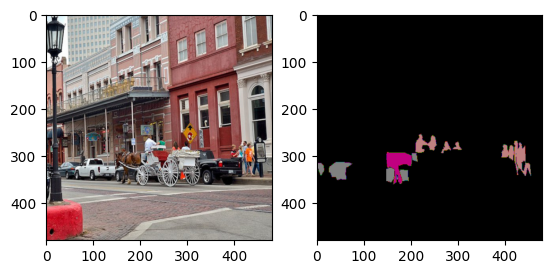

In [38]:
# Random pick one example for visualization:
import random
from datetime import datetime
random.seed(datetime.now())
idx = random.randint(0, len(trainset))
img, mask = trainset[idx]
from gluoncv.utils.viz import get_color_pallete 
# get color pallete for visualize mask
mask = get_color_pallete(mask , dataset='coco')
 
img = np.transpose((img ).astype(np.uint8), (0, 1, 2)) 
# subplot 1 for img
fig = plt.figure()
fig.add_subplot(1,2,1)

plt.imshow(img)
# subplot 2 for the mask 
fig.add_subplot(1,2,2)
plt.imshow(mask)
# display
plt.show()

In [26]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Network Arcitecture

In [39]:
class TileEncoderNet(torch.nn.Sequential):
    def __init__(self):
        super().__init__() 
        self.layer_1 = torch.nn.Sequential(
            torch.nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1), 
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=2, stride=2) 
            ) 
            
        self.layer_2 = torch.nn.Sequential(
            torch.nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1), 
            torch.nn.ReLU(inplace=True), 
            torch.nn.MaxPool2d(kernel_size=2, stride=2),  
            )  

    def forward(self, x):  
        return self.layer_2(self.layer_1(x))
  
tileEncoderModule = TileEncoderNet().to(device)
   
def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1), 
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1), 
        nn.ReLU(inplace=True)
    )  

class ConUpsample(torch.nn.Module):
    def __init__(self,cmodule):
        super(ConUpsample, self).__init__()  
        self.cmodule = cmodule
    def forward(self, x, skip):
        concat = F.interpolate(x, scale_factor=2, mode="bilinear") 
        concat  =  torch.cat([concat, skip], dim=1)
        return self.cmodule(concat)

class TileDecoderNet(torch.nn.Module):
    def __init__(self,n_classs = 21):
        super(TileDecoderNet, self).__init__()  
 
        self.concat_1 = ConUpsample( double_conv( 16+32, 32))    
        self.conv_d_0 = double_conv(32, 16)  
        self.conv_final=  nn.Conv2d(16, n_classs, 3, padding=1)
 
    def forward(self, input, skip):   
        out = self.concat_1(input, skip[0].to(input.device)) 

        out = F.interpolate(out, scale_factor=2, mode="bilinear") 
        out = self.conv_d_0(out)  

        return self.conv_final(out) 
tileDecoderModule =  TileDecoderNet().to(device) 

class EncoderDecoder(torch.nn.Module):
    def __init__(self,encoder=None):
        super(EncoderDecoder, self).__init__() 
      
        self.layer_4 = torch.nn.Sequential( 
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1), 
            nn.BatchNorm2d(64), torch.nn.ReLU(inplace=True), 
            torch.nn.MaxPool2d(kernel_size=2, stride=2), 
        )
        self.layer_5 = torch.nn.Sequential( 
            torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),nn.BatchNorm2d(128), 
            torch.nn.ReLU(inplace=True), 
            torch.nn.MaxPool2d(kernel_size=2, stride=2), 
        )
        self.layer_6 = torch.nn.Sequential( 
            torch.nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1), 
            nn.BatchNorm2d(256),
            torch.nn.ReLU(inplace=True), 
            torch.nn.MaxPool2d(kernel_size=2, stride=2), 
        )

        self.conv_d_11 = double_conv(128+256, 128)  
        self.conv_d_22 = double_conv(64 + 128, 64) 
        self.conv_d_33 = double_conv(32 + 64, 32) 

    def forward(self,input): 
        x0 = input
        x1 = self.layer_4(input)
        x2 = self.layer_5(x1)
        x3 = self.layer_6(x2) 
       
        x = F.interpolate(x3, scale_factor=2, mode="bilinear")
        x = torch.cat([x, x2], dim=1)
        x = self.conv_d_11(x) 
      
        x = F.interpolate(x, scale_factor=2, mode="bilinear")
        x = torch.cat([x, x1], dim=1)
        x = self.conv_d_22(x)  

        x = F.interpolate(x, scale_factor=2, mode="bilinear")
        x = torch.cat([x, x0], dim=1)
        x = self.conv_d_33(x) 

        return x
encoderDecoderModule = EncoderDecoder().to(device)       
     

Initialize network and optimizer

In [11]:
for mod in tileEncoderModule.modules():
    if isinstance(mod, torch.nn.Conv2d):
        torch.nn.init.kaiming_normal_(mod.weight, nonlinearity='relu')
        mod.bias.data.fill_(0)
    
for mod in tileDecoderModule.modules():
    if isinstance(mod, torch.nn.Conv2d):
        torch.nn.init.kaiming_normal_(mod.weight, nonlinearity='relu')
        mod.bias.data.fill_(0)

for mod in encoderDecoderModule.modules():
    if isinstance(mod, torch.nn.Conv2d):
        torch.nn.init.kaiming_normal_(mod.weight, nonlinearity='relu')
        mod.bias.data.fill_(0)

Copy Weight

In [41]:
original_initialization_encoder = copy.deepcopy(tileEncoderModule.state_dict())
original_initialization_decoder = copy.deepcopy(tileDecoderModule.state_dict())
original_initialization_convt = copy.deepcopy(encoderDecoderModule.state_dict())

Backward Hooks

In [42]:
gather_gradient = c_bool(False)
class HSides(Structure):
    _fields_ = [("x_min", c_int),
                ("y_min", c_int),
                ("x_max", c_int),
                ("y_max", c_int) ]
side = HSides(0, 0, 0, 0)  
stream_dim= (11,11)
encoder_gradients = np.zeros(stream_dim,dtype=object)
gather_gradient = c_bool(False)
def gather_skip_conn_gradient_f_decoder(side):  
    def hook_fn(module, grad_input, grad_output):
        if gather_gradient.value: 
            if isinstance(encoder_gradients[side.y_min][side.x_min], list): 
                encoder_gradients[side.y_min][side.x_min].append(grad_input[1].detach().to('cpu', non_blocking=True))
            else:
                encoder_gradients[side.y_min][side.x_min] = [grad_input[1].detach().to('cpu', non_blocking=True)] 
               
    return hook_fn

   
def propagate_skip_conn_gradient_to_encoder_v(side):  
    def enc_hook_fn__(module,grad_input, grad_output):
        if len(encoder_gradients[side.y_min][side.x_min])> 0:    
            grad_input_ = grad_input[0] + \
                    encoder_gradients[side.y_min][side.x_min].pop().to(grad_input[0].device, non_blocking=True)    
            return (grad_input_, )
    return enc_hook_fn__ 
no_stream_input_grad =[]
def no_stream_fn(module,grad_input, grad_output):
      no_stream_input_grad.append(grad_input[0]) 

Model

In [4]:

stream_losses = []
stream_val_losses = []
stream_dice_value = []

losses = []
val_losses = []
dice_value = []

In [43]:
params = (list(tileEncoderModule.parameters())  + list(encoderDecoderModule.parameters()) + list(tileDecoderModule.parameters()))
optimizer = torch.optim.Adam(params, lr=0.00001, weight_decay=1e-6)
criterion = nn.CrossEntropyLoss()

DICE Loss

In [44]:
def multi_class_dice_coeff(true, logits,device, eps=1e-7):
    """Computes the Sørensen-Dice coefficient for multi-class.
    Args:
        true: a tensor of shape [B, 1, H, W].
        logits: a tensor of shape [B, C, H, W]. Corresponds to
            the raw output or logits of the model.
        eps: added to the denominator for numerical stability.
    Returns:
        dice_coeff: the Sørensen-Dice coefficient.
    """
    num_classes = logits.shape[1]
    if num_classes == 1:
        true_1_hot = torch.eye(num_classes + 1).to(device)[true.squeeze(1)]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        true_1_hot_f = true_1_hot[:, 0:1, :, :]
        true_1_hot_s = true_1_hot[:, 1:2, :, :]
        true_1_hot = torch.cat([true_1_hot_s, true_1_hot_f], dim=1)
        pos_prob = torch.sigmoid(logits)
        neg_prob = 1 - pos_prob
        probas = torch.cat([pos_prob, neg_prob], dim=1)
    else:
        true_1_hot = torch.eye(num_classes).to(device)[true.squeeze(1)] 
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        probas = F.softmax(logits, dim=1)
    true_1_hot = true_1_hot.type(logits.type())
    dims = (0,) + tuple(range(2, true.ndimension()))
    intersection = torch.sum(probas * true_1_hot, dims)
    cardinality = torch.sum(probas + true_1_hot, dims)
    dice_coeff = (2. * intersection / (cardinality + eps)).mean()  
    
    return dice_coeff

def dice_loss(true, logits, device, eps=1e-7):
    """Computes the Sørensen-Dice loss, which is 1 minus the Dice coefficient.
    Args:
        true: a tensor of shape [B, 1, H, W].
        logits: a tensor of shape [B, C, H, W]. Corresponds to
            the raw output or logits of the model.
        eps: added to the denominator for numerical stability.
    Returns:
        dice_loss: the Sørensen-Dice loss.
    """
    return 1 - multi_class_dice_coeff(true, logits,device, eps)

Training

In [7]:
def run(epochs=100, megaseg=False):
    modelN = 'model_l1e_3_coco_'
  
    dice_val_best = 0.0 
    # train_scores = []
    for epoch in range(epochs): 
        tileEncoderModule.train()
        encoderDecoderModule.train()
        tileDecoderModule.train()
        running_loss =  []
      
        
        for images, labels in tqdm(trainLoader):
            epoch_dice_score  = 0
            optimizer.zero_grad(set_to_none=True)  
            if megaseg: 
                stream_output, _  = tileEncoderModule(images,None)
                streamin_out_clone = stream_output.detach().requires_grad_(True) 
                pred  = tileDecoderModule(images,streamin_out_clone)   
            else:
                labels = labels.to(device,dtype=torch.long)    
                final_output  = plain_model(images) 

            loss = criterion(final_output, labels)
            dice_l = dice_loss(labels, final_output, device)
            loss += dice_l

            loss.backward()
            if megaseg:
                stream_output.backward(streamin_out_clone.grad)  

            optimizer.step() 
            running_loss.append(loss.detach().item()) 
             
                    
            del images
            del labels
            del loss  
            del final_output
            del dice_l 
            # del dice_score_batch
            if megaseg:
                del stream_output  
                del streamin_out_clone

        if megaseg: 
            stream_losses.append(np.average(running_loss).item())
        else: losses.append(np.average(running_loss).item())


        val_loss = [] 
        tileEncoderModule.eval()
        encoderDecoderModule.eval()
        tileDecoderModule.eval()
        with torch.no_grad(): 
            epoch_dice_scores = 0
           
            for images, labels in valLoader:
                if megaseg: 
                    stream_output, _  = tileEncoderModule(images,None)
                    streamin_out_clone = stream_output.detach().requires_grad_(True) 
                    pred  = tileDecoderModule(images,streamin_out_clone)  
                else:
                    labels = labels.to(device,dtype=torch.long)    
                    final_output  = plain_model(images)   
                    
                loss = criterion(final_output, labels)
                dice_l = dice_loss(labels, final_output, device)
                loss += dice_l 
              
                dice_score_batch = multi_class_dice_coeff( labels,final_output,device)
                epoch_dice_scores += dice_score_batch.item()
                val_loss.append(loss.item())
                

                del images
                del labels
                del loss 
                del dice_l 
                del final_output   
                del dice_score_batch   
                if megaseg:
                    del stream_output  
        
            epoch_dice_score = epoch_dice_scores / len(valLoader)
        if megaseg:
            stream_dice_value.append(epoch_dice_score)
        else: dice_value.append(epoch_dice_score)
        del  epoch_dice_scores
        
            
        if megaseg: stream_val_losses.append(np.average(val_loss).item())
        else: val_losses.append(np.average(val_loss).item())
         
   
            
        plot_losses()

def plot_losses():
    clear_output(wait=True)
    fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
    ax[0].plot(np.arange(len(losses)), losses, label="loss, Conventional case")
    ax[0].plot(np.arange(len(stream_losses)), stream_losses, label="loss, MegaSeg", color="C1")

    ax[1].plot(np.arange(len(losses)), losses, label="train loss, Conventional case")
    ax[1].plot(np.arange(len(val_losses)), val_losses, label="validation loss, normal case")
    
    ax[2].plot(np.arange(len(stream_losses)), stream_losses, label="train loss, MegaSeg", color="C1")
    ax[2].plot(np.arange(len(stream_val_losses)), stream_val_losses, label="validation loss, MegaSeg", color="C2")
    
    ax[3].plot(np.arange(len(dice_value)), dice_value, label="Conventional dice Score")
    ax[3].plot(np.arange(len(stream_dice_value)), stream_dice_value, label="MegaSeg dice score")
    ax[0].legend() 
    ax[1].legend() 
    ax[2].legend() 
    # ax[3].legend()
    plt.show();

Conventionl Model

In [46]:
class PlainModel(nn.Module):
    def __init__(self, conv_module,convt_net, decoder_module):
        super().__init__()
        self.conv_module = conv_module
        self.decoder_module = decoder_module
        self.convt_net = convt_net

    def forward(self, image_batch):
     
        image_batch = image_batch.to(device)
        image_batch = image_batch.permute(0, 3, 1, 2).contiguous()
        image_batch = image_batch.float().div(255.0)
        image_batch = transforms.functional.normalize(
            tensor=image_batch,
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225],
        )
        st_1 = self.conv_module[0](image_batch)
        st_2 = self.conv_module[1](st_1)
        no_s = self.convt_net(st_2)
      
        output  = self.decoder_module(no_s,[st_1]) 
        return output

plain_model = PlainModel(tileEncoderModule, encoderDecoderModule, tileDecoderModule).to(device)

Train Conventionl Method

In [47]:
# # # initialize the dataloaders after re-seed
torch.manual_seed(0)
tileEncoderModule.load_state_dict(original_initialization_encoder)
encoderDecoderModule.load_state_dict(original_initialization_convt) 
tileDecoderModule.load_state_dict(original_initialization_decoder)
batchSize = 80
trainLoader = torch.utils.data.DataLoader(trainset, batch_size=batchSize, shuffle=True,num_workers=1, pin_memory=torch.cuda.is_available()) 
valLoader = torch.utils.data.DataLoader(valset, batch_size=batchSize, shuffle=False,num_workers=1, drop_last=True, pin_memory=torch.cuda.is_available()) 

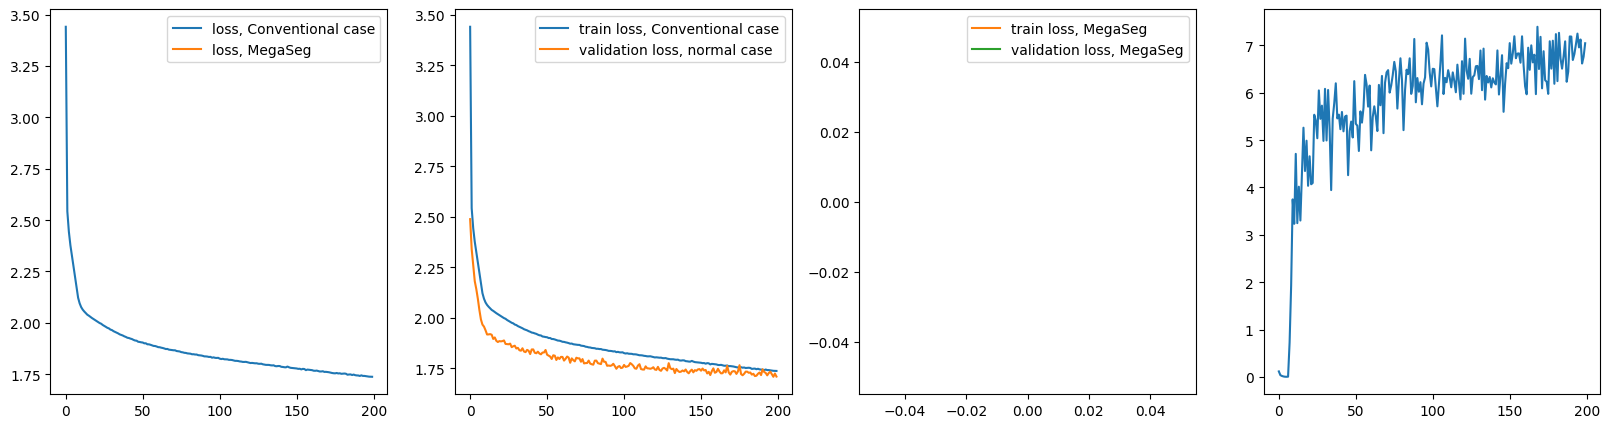

In [9]:
run(epochs=200, megaseg=False)

Train MegaSeg

In [20]:
# initialize the dataloaders after re-seed
torch.manual_seed(0)
tileEncoderModule.load_state_dict(original_initialization_encoder)
encoderDecoderModule.load_state_dict(original_initialization_convt) 
tileDecoderModule.load_state_dict(original_initialization_decoder)
batchSize = 80
trainLoader = torch.utils.data.DataLoader(trainset, batch_size=batchSize, shuffle=True,num_workers=1, pin_memory=torch.cuda.is_available()) 
valLoader = torch.utils.data.DataLoader(valset, batch_size=batchSize, shuffle=True,num_workers=1, drop_last=True, pin_memory=torch.cuda.is_available()) 
 

Gather Skip connection Gradient

In [21]:
all_hooks = []
for i, layer in enumerate(list(tileDecoderModule.children())[:1]): #number of skip connection layer in the encoder
        hook = layer.register_full_backward_hook(gather_skip_conn_gradient_f_decoder(side))
        all_hooks.append(hook)

for i, layer in enumerate(list(tileEncoderModule.children())[1:]):
        hook = layer.register_full_backward_hook(propagate_skip_conn_gradient_to_encoder_v(side))
        all_hooks.append(hook)

In [22]:
stream_losses = []
stream_val_losses = []
stream_dice_value = []

tile_size = 128  
 
stream_model = TileEncoder(
    loader_module=PlainLoaderModule(segmentation_task=True).to(device),
    conv_module=tileEncoderModule.to(device),   
    tile_size=tile_size, 
    skip_layer=[0,1],
    emb_crop_size=11,   
    emb_stride_size=4,
    hook_side = pointer(side)    
) 
decoder = TileDecoder(
    decoder=tileDecoderModule.to(device),
    No_stream =encoderDecoderModule.to(device) ,
    encoder_tile_size = stream_model.tile_size,
    tile_size=stream_model.tile_size // stream_model.emb_stride_size, 
    emb_crop_size = stream_model.emb_crop_size * stream_model.emb_stride_size,
    emb_stride_size= stream_model.emb_stride_size,
    encoder_crop_size=stream_model.emb_crop_size,   
    gather_grad = pointer(gather_gradient),
    hook_side = pointer(side)  
)
 

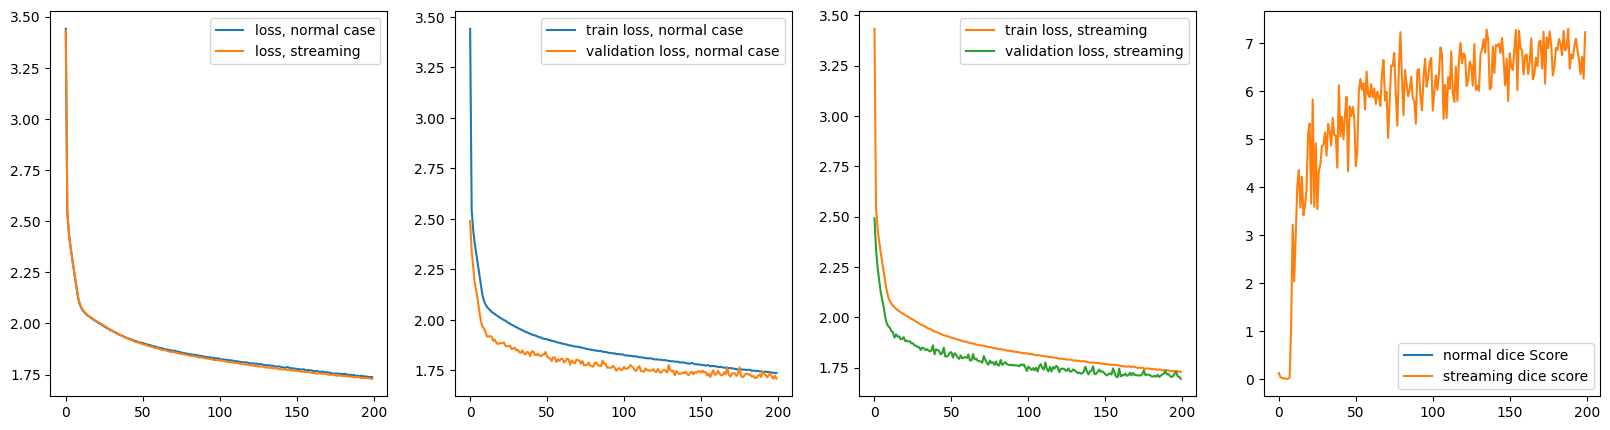

In [25]:
run(epochs=200, megaseg=True)

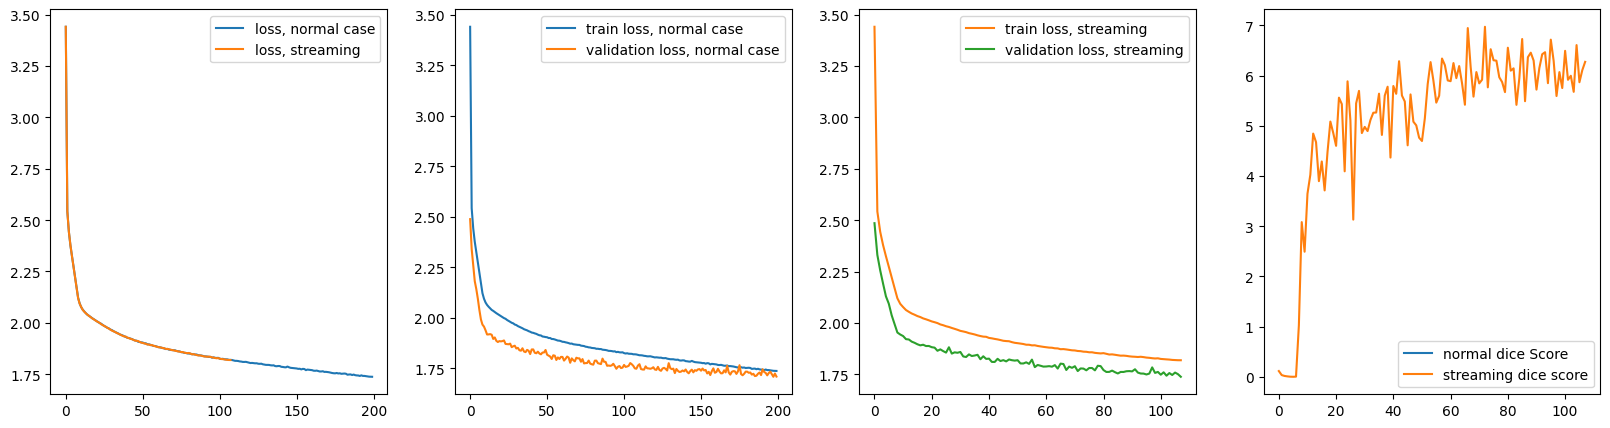

 57%|█████▋    | 139/246 [26:21<20:15, 11.36s/it]

In [ ]:
run(epochs=200, megaseg=True)

In [26]:
np.save('results/_stream_losses__augmentation_dice', stream_losses)
np.save('results/_stream_val_losses__augmentation_dice', stream_losses)
np.save('results/_stream_dice_value__augmentation_dice', stream_dice_value)